# Onderzoeksvraag 1

In hoeverre is de omzet (gross) van een film te voorspellen op basis van de populariteit op Facebook en IMDB?

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error


In [113]:
bestand = "movie-1-cleaned.csv"
df = pd.read_csv(bestand, encoding='utf-8')

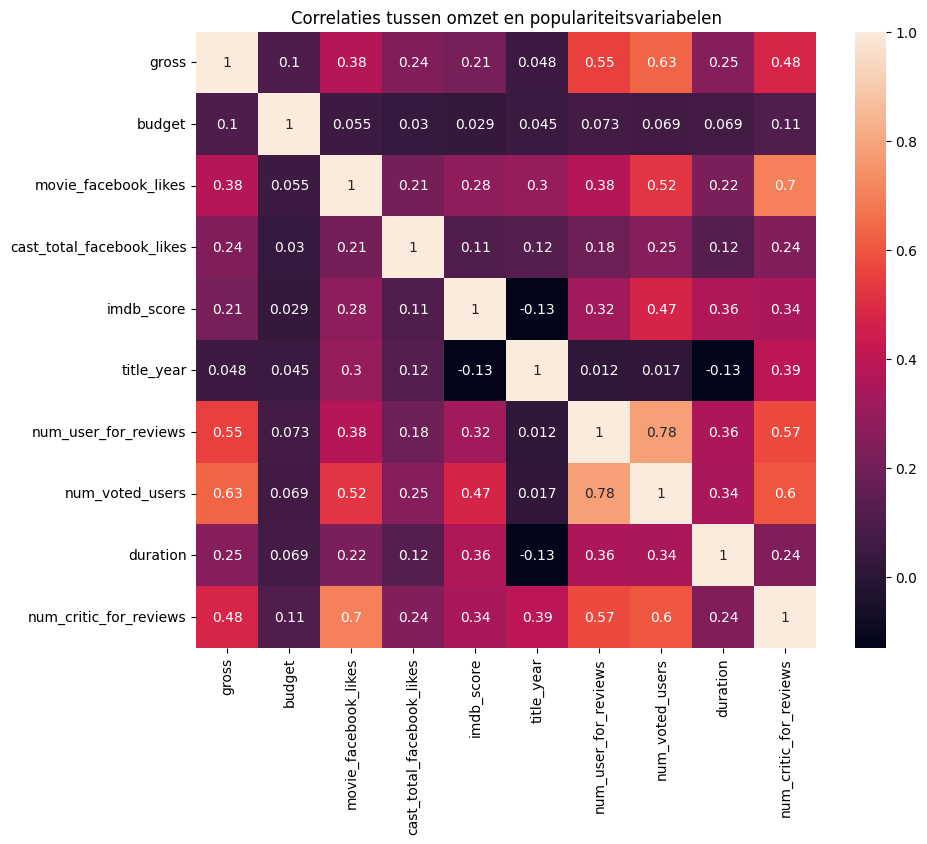

In [114]:
# Beschrijving
df.describe()

# Missende waarden
df.isnull().sum()

# Correlaties
plt.figure(figsize=(10,8))
sns.heatmap(df[['gross', 'budget', 'movie_facebook_likes', 'cast_total_facebook_likes', 'imdb_score', 'title_year', 'num_user_for_reviews', 'num_voted_users', 'duration', 'num_critic_for_reviews' ]].corr(), annot=True)
plt.title("Correlaties tussen omzet en populariteitsvariabelen")
plt.show()


In [115]:
df['log_budget'] = np.log1p(df['budget'])
df['log_gross'] = np.log1p(df['gross'])

df['log_num_user_for_reviews'] = np.log1p(df['num_user_for_reviews'])
df['log_num_voted_users'] = np.log1p(df['num_voted_users'])
df['log_movie_facebook_likes'] = np.log1p(df['movie_facebook_likes'])

df['interaction_budget_imdb'] = df['log_budget'] * df['imdb_score']
df['review_ratio'] = df['log_num_user_for_reviews'] / (df['log_num_voted_users'] + 1e-6)
df['movie_age'] = 2025 - df['title_year']

In [116]:
X = df[['director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
        'actor_3_facebook_likes', 'cast_total_facebook_likes', 'log_movie_facebook_likes',
        'imdb_score', 'log_num_voted_users', 'log_budget', 'log_num_user_for_reviews',
        'num_critic_for_reviews', 'interaction_budget_imdb', 'review_ratio', 'movie_age']]

y = df['log_gross']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Gridsearch niet runnen

In [111]:
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
    'max_depth': [10, 15, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', 0.5, None],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,                # aantal combinaties (meer = grondiger)
    cv=5,                     # 5-fold cross validation
    scoring='r2',             # R² score als metric
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("\nBeste parameters:")
print(random_search.best_params_)

best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test)
r2_best = r2_score(y_test, y_pred)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nRandomForest na tuning -> R²: {r2_best:.3f}, RMSE: {rmse_best:.3f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Beste parameters:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 50, 'bootstrap': True}

RandomForest na tuning -> R²: 0.634, RMSE: 1.334


In [122]:
rf = RandomForestRegressor(
     n_estimators=800,
    min_samples_split=5,       
    min_samples_leaf=2,
    max_features='sqrt',        
    max_depth=20,
    bootstrap=True,            
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R²: {r2_rf:.3f}, RMSE: {rmse_rf:.3f}")

R²: 0.622, RMSE: 1.356


Overfitting verminderen
→ beperk de diepte van bomen, verhoog min_samples_split en min_samples_leaf, beperk aantal features per split.

Model verbeteren
→ optimaliseer aantal bomen (n_estimators) en de manier van splitsen (max_features).

R²: 0.628, RMSE: 1.345

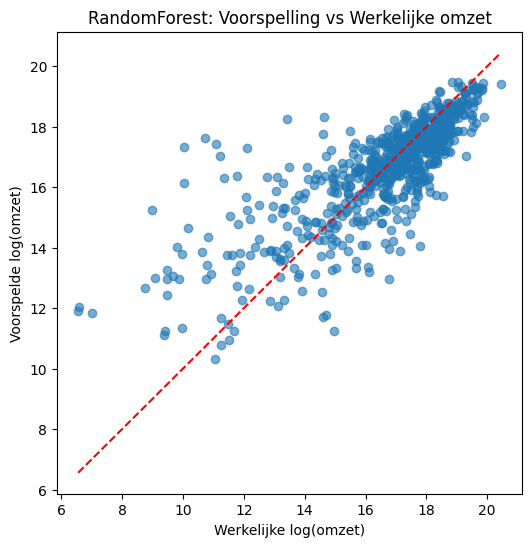

In [123]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Werkelijke log(omzet)")
plt.ylabel("Voorspelde log(omzet)")
plt.title("RandomForest: Voorspelling vs Werkelijke omzet")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonale lijn
plt.show()

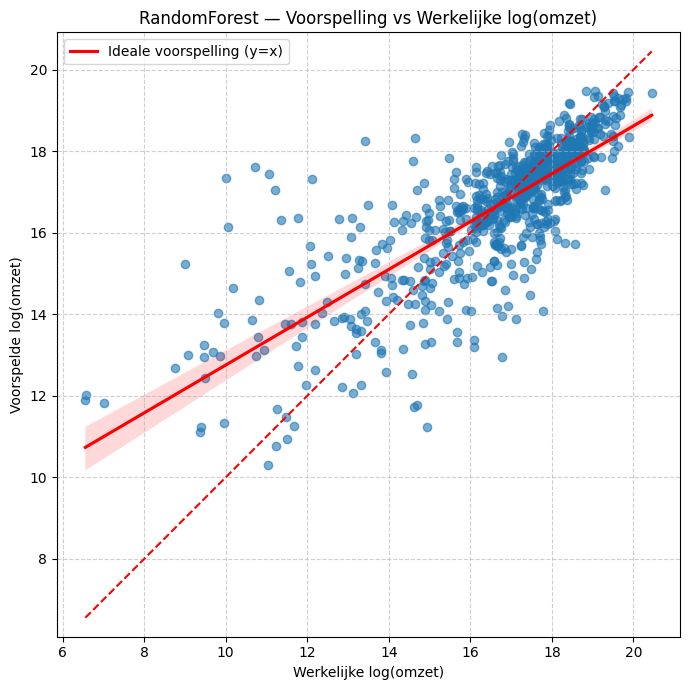

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot van werkelijke vs voorspelde waarden
plt.figure(figsize=(7,7))

# Scatterplot met regressielijn
sns.regplot(
    x=y_test,
    y=y_pred,
    line_kws={'color': 'red', 'label': 'Ideale voorspelling (y=x)'},
    scatter_kws={'alpha': 0.6}
)

# Diagonale lijn (perfecte voorspelling)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# Labels en titel
plt.xlabel("Werkelijke log(omzet)")
plt.ylabel("Voorspelde log(omzet)")
plt.title("RandomForest — Voorspelling vs Werkelijke log(omzet)")

# Asverhouding gelijk voor correcte vergelijking
plt.axis('equal')

# Raster en legenda
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Plot weergeven
plt.show()


In [124]:
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print(f"Gemiddelde cross-val R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

Gemiddelde cross-val R²: 0.331 ± 0.077


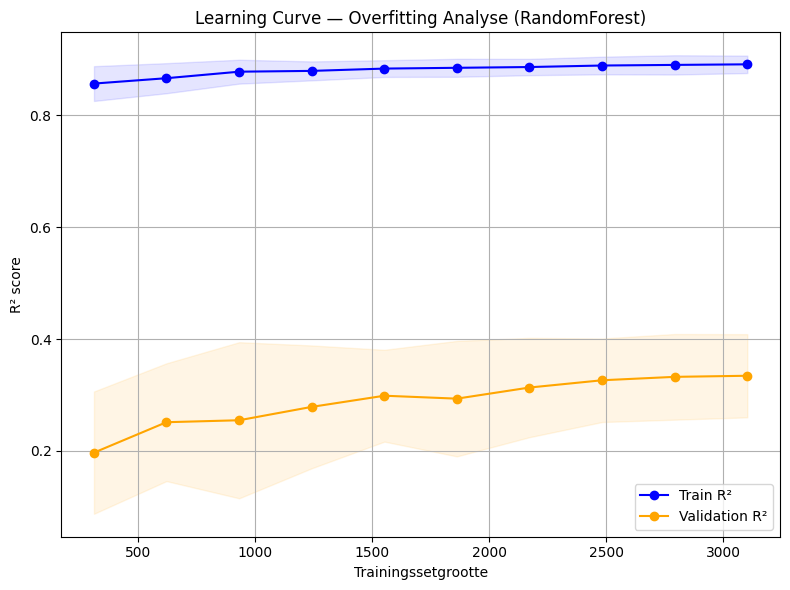

In [125]:
train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Gemiddelde en standaarddeviatie
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
test_mean  = test_scores.mean(axis=1)
test_std   = test_scores.std(axis=1)

# Plotten
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train R²')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Validation R²')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')

plt.xlabel("Trainingssetgrootte")
plt.ylabel("R² score")
plt.title("Learning Curve — Overfitting Analyse (RandomForest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


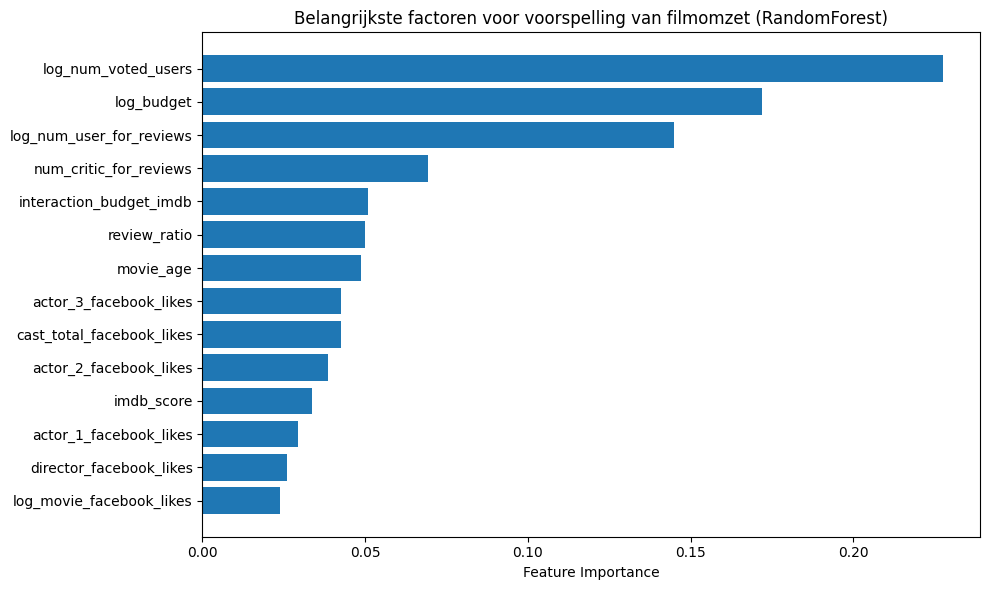

In [126]:
importances = rf.feature_importances_
feature_names = X.columns

# DataFrame met importances
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plotten
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()  # Belangrijkste bovenaan
plt.xlabel("Feature Importance")
plt.title("Belangrijkste factoren voor voorspelling van filmomzet (RandomForest)")
plt.tight_layout()
plt.show()

## Modelen geprobeerd 
### Lineair modelen
Linear Regression

Ridge Regression

Lasso Regression 

ElasticNet

### Boomgebaseerde modellen
Decision Tree

Random Forest

Extra Trees

Gradient Boosting

### Niet-lineair model
KNN Regressor


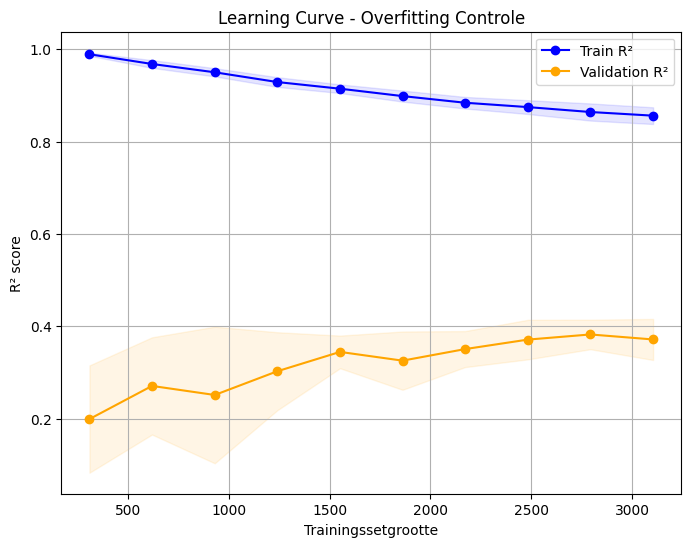

In [34]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Gebruik het beste XGBoost-model
model = best_model

# Bereken learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='r2', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

# Gemiddelde en standaarddeviatie
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Plotten
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train R²')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Validation R²')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')

plt.xlabel("Trainingssetgrootte")
plt.ylabel("R² score")
plt.title("Learning Curve - Overfitting Controle")
plt.legend()
plt.grid(True)
plt.show()
